In [1]:
# Import all libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.graph_objects as go

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv')
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')
actors_list = pd.read_csv('cleaned_datasets/actors_list_clean.csv')

# How awards influence the movies?

For this, let's try to first see some general trends by plotting movies with nonimated cast and those without.

In [3]:
# Add the average fame, liked, disliked and neutral scores from the characters dataframe per movie to the movies dataframe
values = characters.groupby('freebase_movie_id',as_index=False).mean()#.agg({'Fame':'mean','Liked':'mean','Disliked':'mean','Neutral':'mean'})
movies = pd.merge(movies, values[['freebase_movie_id','Fame','Liked','Disliked','Neutral']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies = movies.drop(['freebase_movie_id'], axis=1)
movies.head()

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,Fame,Liked,Disliked,Neutral
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,4.9,56894.0,0.0,4.529412,0.0,77.0,13.705882,9.117647,1.117647,3.411765
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,5.6,40.0,0.0,0.500000,0.0,2.0,0.000000,0.000000,0.000000,0.000000
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,5.9,623.0,0.0,1.666667,0.0,5.0,0.000000,0.000000,0.000000,0.000000
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.8,16.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.8,2268.0,0.0,3.750000,0.0,15.0,15.250000,9.000000,1.250000,4.750000


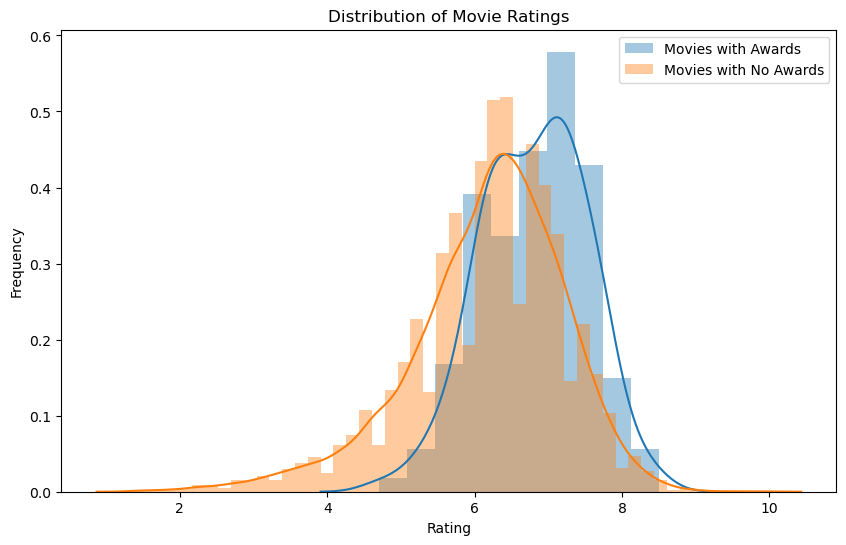

In [4]:
# Split the movies into two dataframes, one for the movies that have an award cumcount and one for the movies with no awards
movies_awards = movies[movies['award_cumcount'] > 10]
movies_no_awards = movies[movies['award_cumcount'] <= 10]

# Plot the ratings distribution for movies both movies with and without awards on the same plot
plt.figure(figsize=(10,6))
sns.distplot(movies_awards['averageRating'], label='Movies with Awards')
sns.distplot(movies_no_awards['averageRating'], label='Movies with No Awards')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

As we can see, with out first look it seems like the distribution of ratings is pretty similar between both groups.

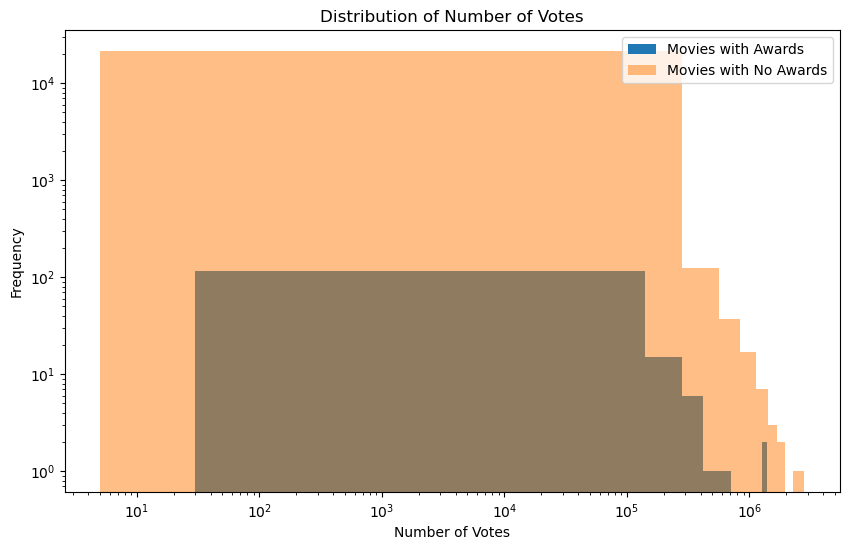

In [27]:
# Lets now look at the distribution of the number of votes for both types of movies using a histogram
plt.figure(figsize=(10,6))
plt.hist(movies_awards['numVotes'], label='Movies with Awards')
plt.hist(movies_no_awards['numVotes'], label='Movies with No Awards', alpha=0.5)
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Frequency')
plt.legend()

As we can see, the awarded casts produced movies with a much higher number of votes, maybe having a high number of votes increases your rating?

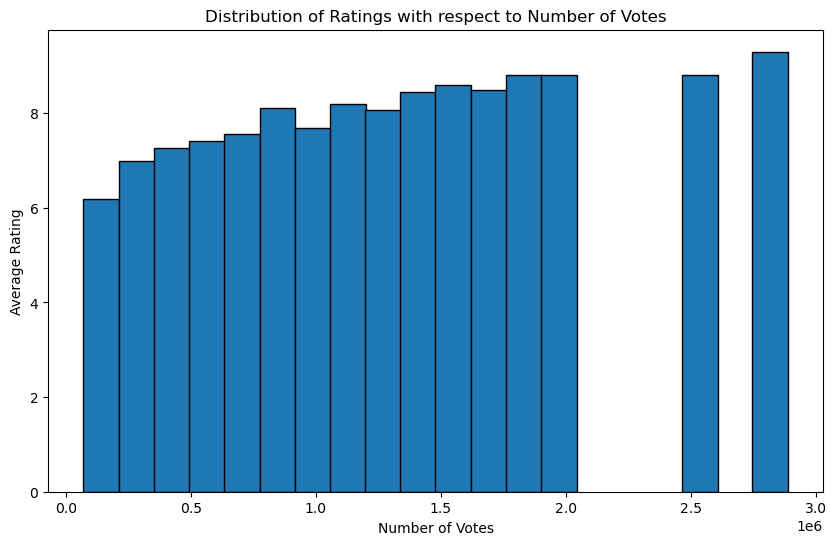

In [28]:
# Lets now look at the distribution of the number of votes per rating for both types of movies using a histogram

# Calculate the mean of 'averageRating' for each bin
bin_means = movies.groupby(pd.cut(movies['numVotes'], bins=20))['averageRating'].mean()
bin_midpoints = [(bin.left + bin.right) / 2 for bin in bin_means.index]
bin_width = bin_means.index[1].left - bin_means.index[0].left

# Plotting the histogram with mean values
plt.figure(figsize=(10,6))
plt.bar(bin_midpoints, bin_means.values, edgecolor='black', align='edge', width=bin_width)

# Adding labels and title
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.title('Distribution of Ratings with respect to Number of Votes')

# Show the plot
plt.show()


Looks like a trend!

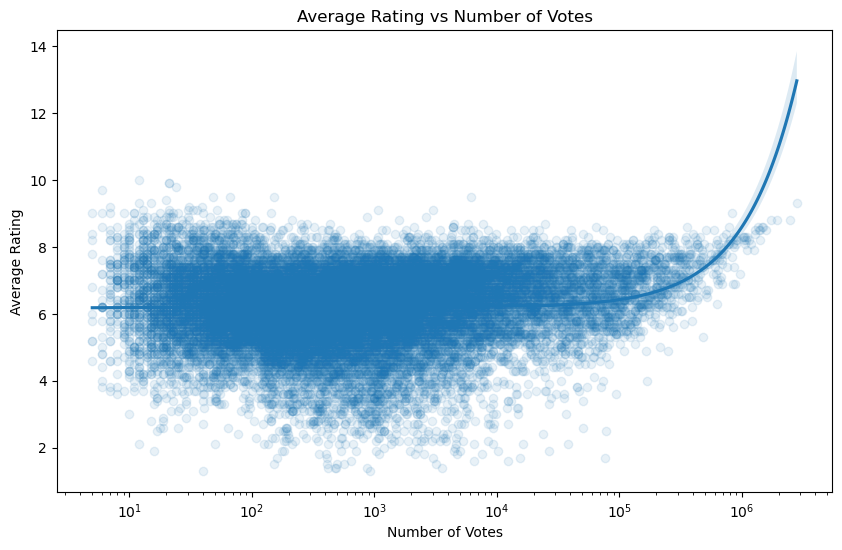

In [29]:
# Lets now do a regression plot of the average rating vs the number of votes for both types of movies
plt.figure(figsize=(10,6))
sns.regplot(x='numVotes', y='averageRating', data=movies,scatter_kws={'alpha':0.1})
# Make the scatter points more transparent so we can see the density of the points
plt.title('Average Rating vs Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.xscale('log')

In [30]:
# Probably would be nice to normalize the number of votes
# TODO check regression with awards and without awards, see if the difference is significant

# Ols regression of ratings vs log(number of votes) for movies
model = ols('averageRating ~ np.log(numVotes)', movies).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     341.5
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           9.61e-76
Time:                        15:34:43   Log-Likelihood:                -37831.
No. Observations:               25515   AIC:                         7.567e+04
Df Residuals:                   25513   BIC:                         7.568e+04
Df Model:                           1                                         
Covariance Type:            nonrobust  

# Time Analysis of awards

In [31]:
import plotly.express as px
import plotly.graph_objs as go
from ipywidgets import widgets, VBox

# Because the dataset of awards starts at year 1927
award_df = movies[movies['year_release'].astype(int)>= 1926]
print(len(award_df))

24744


In [32]:
fig = px.histogram(award_df, x='numVotes', nbins=50, title='Distribution of Number of Votes')

# Update layout if needed
fig.update_layout(
    xaxis_title='Number of Votes',
    yaxis_title='Count of Movies',
    bargap=0.2  # Gap between bars
)

# Show the plot
fig.show()

print(len(award_df[award_df['numVotes']>=500]))

13480


As seen here, we have a huge amount of movies that have really low numbers of votes. This will lead to false conslusion as a movie with 10 votes and a high rating will be compared in our analysis to movies with more than 100k votes. Therefore, we chose the threshold of 500 votes, so we now consider a dataset of 13'480 movies.

In [33]:
award_df = award_df[award_df['numVotes'] >= 500]

In [34]:
f = go.FigureWidget(
    data=[{
        'type': 'scatter',
        'mode': 'markers',
        'marker': {'size': 10, 'opacity': 0.8, 'line': {'width': 2}}
    }], 
    layout={
        'height': 400  # Adjust the height of the plot here
    }
)

# Function to plot with Plotly
def plot_awards_ratings(year):
    # Filter the dataframe for the selected year
    data_year = award_df[award_df['year_release'] == year]

    # Update the scatter plot with the new data
    f.data[0].x = data_year['award_cumcount']
    f.data[0].y = data_year['averageRating']
    f.data[0].text = data_year['name'] + '<br>Votes: ' + data_year['numVotes'].astype(str) + '<br>Rating: ' + data_year['averageRating'].astype(str)

    f.data[0].hoverinfo = 'text'  # Show hover text with movie names

    # Update layout
    f.update_layout(
        title=f'Movie Ratings and Awards Count in {year}',
        xaxis={'title': 'Number of Awards'},
        yaxis={'title': 'IMDb Rating'}
    )

# Slider widget for year selection
year_slider = widgets.IntSlider(
    value=award_df['year_release'].min(),
    min=award_df['year_release'].min(),
    max=award_df['year_release'].max(),
    step=1,
    description='Select Year:',
    continuous_update=True,
    layout=widgets.Layout(width='50%', margin='0 auto 0 auto')
)

# Create the interactive widget
interactive_widget = widgets.interactive(plot_awards_ratings, year=year_slider)

VBox((f, interactive_widget))

    'data': [{'hoverinfo': 'text',
              'marker': {'line': {'width': 2}…

In [35]:
import ast  # for safely evaluating strings as Python expressions
import matplotlib.pyplot as plt

# Create a copy of the DataFrame for this operation
analysis_df = award_df.copy()

# Safely convert string representations of dictionaries to actual dictionaries in the copy
analysis_df['genres'] = analysis_df['genres'].apply(ast.literal_eval)

# Extract genres and count their occurrences
genre_counts = {}
for row in analysis_df['genres']:
    for genre in row.values():
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Sort genres by frequency and select the top 20
sorted_genres = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)[:20])

# Plotting with Plotly
fig = px.bar(x=list(sorted_genres.keys()), y=list(sorted_genres.values()), 
             labels={'x': 'Genres', 'y': 'Frequency'},
             title='Top 20 Genres Distribution',
             color=list(sorted_genres.keys()),
             hover_data={'Frequency': list(sorted_genres.values())})

fig.show()

In [36]:

from IPython.display import display
import plotly.graph_objs as go
from ipywidgets import widgets, interactive_output, HBox, Layout

copy = award_df.copy()

genre_colors = {
    'Drama': 'darkgrey',
    'Action': 'blue',
    'Comedy': 'green',
    'Thriller': 'darkorange',
    'Romance Film': 'magenta'
}

# Function to safely evaluate strings as dictionaries and extract genre names
def extract_genre_names(genre_string):
    try:
        # Safely evaluate the string as a dictionary
        genre_dict = ast.literal_eval(genre_string)
        # If the result is a dictionary, return the list of genre names
        if isinstance(genre_dict, dict):
            return list(genre_dict.values())
    except (ValueError, SyntaxError):
        # In case of an error, return an empty list
        return []
    
    # If the string was not a dictionary, return an empty list
    return []

# Assuming the 'genres' column contains string representations of lists of dictionaries
award_df['genre_names'] = award_df['genres'].apply(extract_genre_names)

# Determine the top 5 genres
top_genres = award_df.explode('genre_names')['genre_names'].value_counts().head(5).index.tolist()


# Define your FigureWidget
fig = go.FigureWidget()

# Define widgets with layout properties for centering
genre_dropdown = widgets.Dropdown(
    options=top_genres,
    value=top_genres[0],
    description='Genre:',
    layout=Layout(width='50%', justify_content='center')
)

year_slider = widgets.IntSlider(
    value=award_df['year_release'].min(),
    min=award_df['year_release'].min(),
    max=award_df['year_release'].max(),
    step=1,
    description='Year:',
    layout=Layout(width='50%', justify_content='center')
)

# Function to update the plot based on the selected genre and year
def update_plot(genre_choice, year_choice):
    with fig.batch_update():
        genre_color = genre_colors.get(genre_choice, 'grey')
        fig.data = []
        # Filter the DataFrame for the selected genre and year
        filtered_df = award_df[(award_df['genre_names'].apply(lambda genres: genre_choice in genres)) &
                               (award_df['year_release'] == year_choice)]
        
        # Adding scatter plot with custom hover data
        fig.add_scatter(
            x=filtered_df['award_cumcount'], 
            y=filtered_df['averageRating'], 
            mode='markers',
            marker=dict(color=genre_color),
            hovertext=filtered_df['name'] + '<br>Rating: ' + filtered_df['averageRating'].astype(str),  
            hoverinfo='text'
        )
            
        fig.update_layout(
            title= {
                'text': f"<b>Average IMDB Rating by Award Count for {genre_choice} Movies in {year_choice}</b>",  # Use <b> tags to make it bold
                'y':0.9,
                'x':0.5,
                'xanchor': 'center'
            },
            xaxis_title='Award Cumulative Count',                
            yaxis_title='Average Rating',
        )
        # Change the color of the dropdown to match the selected genre
        genre_dropdown.style.button_color = genre_color

# Display widgets in a box with center alignment
widgets_container = HBox([genre_dropdown, year_slider], layout=Layout(justify_content='center', align_items='center'))

# Interactive output
out = interactive_output(update_plot, {'genre_choice': genre_dropdown, 'year_choice': year_slider})

# Set the layout for the figure
fig.update_layout(
    title= {
            'text': f"<b>Average IMDB Rating by Award Count</b>",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center'
    },
    xaxis_title='Award Cumulative Count',
    yaxis_title='Average Rating',
)

# Display the layout
display(fig)
display(widgets_container, out)

AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'hovertext': array(['The Scarlet Letter<br>Rating: 7.6',
                                  'Bardelys the Magnificent<br>Rating: 7.1',
                                  'Beverly of Graustark<br>Rating: 6.6',
                                  'Flesh and the Devil<br>Rating: 7.6', 'La Bohème<br>Rating: 7.2',
                                  'The Winning of Barbara Worth<br>Rating: 6.9'], dtype=object),
              'marker': {'color': 'darkgrey'},
              'mode': 'markers',
              'type': 'scatter',
              'uid': 'e53e6271-b2cd-4cf3-9d6d-c6e927efdfcd',
              'x': array([0., 0., 0., 0., 0., 0.]),
              'y': array([7.6, 7.1, 6.6, 7.6, 7.2, 6.9])}],
    'layout': {'template': '...',
               'title': {'text': '<b>Average IMDB Rating by Award Count</b>', 'x': 0.5, 'xanchor': 'center', 'y': 0.9},
               'xaxis': {'title': {'text': 'Award Cumulative Count'}},
               'yaxis': {'title': {'text': 'Average Rating'}}}
})

Output()

# Popularity matching

First, let us visualize our data.

Text(0, 0.5, 'Number of Movies')

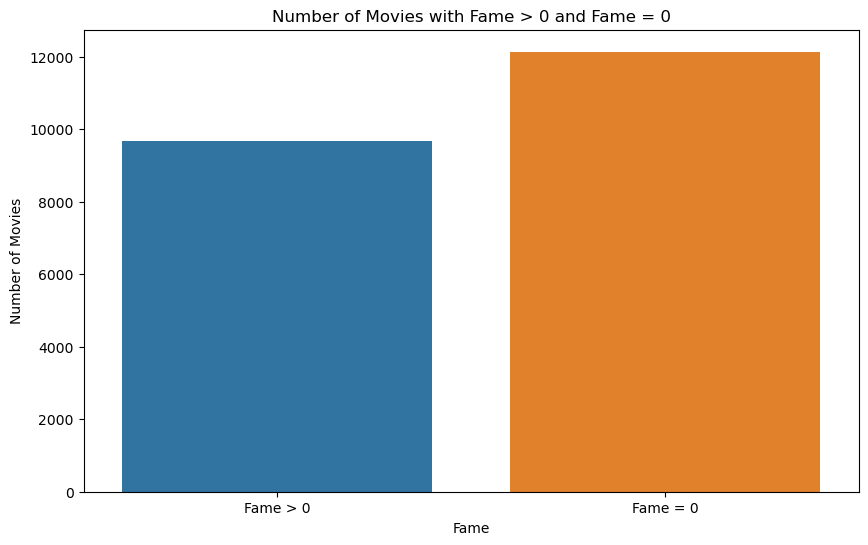

In [6]:
# plot a bar plot with the movies with a fame > 0 and the movies with a fame = 0, use the number of movies as the height of the bar
plt.figure(figsize=(10,6))
sns.barplot(x=['Fame > 0', 'Fame = 0'], y=[len(movies[movies['Fame'] > 0]), len(movies[movies['Fame'] == 0])])
plt.title('Number of Movies with Fame > 0 and Fame = 0')
plt.xlabel('Fame')
plt.ylabel('Number of Movies')


In [7]:
# Check for duplicates in the character dataset
duplicates = characters.duplicated()

# Visualize the duplicated rows
if duplicates.any():
    duplicated_rows = characters[duplicates]
    print("Duplicated Rows:")
    print(duplicated_rows)
else:
    print("No duplicates found in the character dataset.")

    # Check for duplicates in the character dataset
    duplicates = characters.duplicated(subset=['freebase_movie_id', 'actor_name','character_name'], keep=False)

    # Visualize the duplicated rows
    if duplicates.any():
        duplicated_rows = characters[duplicates]
        print("Actors who played multiple roles in the same movie:")
        print(duplicated_rows[['freebase_movie_id', 'actor_name', 'character_name']])
    else:
        print("No actors found who played multiple roles in the same movie.")



# show the NaN charcater names
print(characters[characters['actor_name'].isna()])
#149 cases over 130k, so it doesn't make a difference, I will keep them because I suppose they are correct characters for their movies, so it will represent correctly the size of the cast



# remove the duplicates from the characters dataset
characters = characters.drop_duplicates(subset=['freebase_movie_id', 'actor_name','character_name'], keep='first')


No duplicates found in the character dataset.
Actors who played multiple roles in the same movie:
       freebase_movie_id        actor_name           character_name
10            /m/0cc71m5    Richard Harris  Sheriff Sean Kilpatrick
11            /m/0cc71m5    Richard Harris  Sheriff Sean Kilpatrick
819             /m/0bmpm  Barry Fitzgerald        Father Fitzgibbon
820             /m/0bmpm  Barry Fitzgerald        Father Fitzgibbon
932           /m/0b0k5r_    William Holden            Bill Seacroft
...                  ...               ...                      ...
169305        /m/07kfdtm               NaN                      NaN
169306        /m/07kfdtm               NaN                      NaN
170092        /m/076xyj6               NaN                      NaN
170316         /m/03qfpk      Adam Sandler                      Pip
170317         /m/03qfpk      Adam Sandler                      Pip

[532 rows x 3 columns]
        wikipedia_movie_id freebase_movie_id movie_release_dat

We add some metrics to have a more complete dataset

In [8]:
#copy of the movies dataframe to prevent to modify the original one
movies_copy = movies.copy()
# add the number of characters per movie to the movies dataframe
characters_per_movie = characters.groupby('freebase_movie_id',as_index=False).agg({'character_name':'size'}).reset_index()
movies_copy = pd.merge(movies_copy, characters_per_movie[['freebase_movie_id','character_name']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)
movies_copy = movies_copy.rename(columns={'character_name':'num_characters'})

# add the number of actors per movie to the movies dataframe
actors_per_movie = characters.groupby('freebase_movie_id',as_index=False)['actor_name'].nunique()
movies_copy = pd.merge(movies_copy, actors_per_movie[['freebase_movie_id','actor_name']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)
movies_copy = movies_copy.rename(columns={'actor_name':'num_actors'})

# add the number of actors with fame >0 per movie to the movies dataframe
actors_fame_per_movie = characters[characters['Fame'] > 0].groupby('freebase_movie_id',as_index=False)['actor_name'].nunique()
movies_copy = pd.merge(movies_copy, actors_fame_per_movie[['freebase_movie_id','actor_name']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)
movies_copy = movies_copy.rename(columns={'actor_name':'num_actors_fame'})

#replace the NaN values with 0 for the number of actors with fame >0
movies_copy['num_actors_fame'] = movies_copy['num_actors_fame'].fillna(0)

# add the fame, liked, disliked and neutral scores from the actors with fame>0 per movie to the movies dataframe
actors_fame_per_movie = characters[characters['Fame'] > 0].groupby('freebase_movie_id',as_index=False).mean()
movies_copy = pd.merge(movies_copy, actors_fame_per_movie[['freebase_movie_id','Fame','Liked','Disliked','Neutral']], left_on='freebase_id', right_on='freebase_movie_id', how='left')
movies_copy = movies_copy.drop(['freebase_movie_id'], axis=1)

#rename the columns to avoid confusion
movies_copy = movies_copy.rename(columns={'Fame_y':'fame_only','Liked_y':'liked_only','Disliked_y':'disliked_only','Neutral_y':'neutral_only'})
movies_copy = movies_copy.rename(columns={'Fame_x':'Fame','Liked_x':'Liked','Disliked_x':'Disliked','Neutral_x':'Neutral'})


#replace the NaN values with 0 for the fame_only, liked_only, disliked_only and neutral_only scores
movies_copy['fame_only'] = movies_copy['fame_only'].fillna(0)
movies_copy['liked_only'] = movies_copy['liked_only'].fillna(0)
movies_copy['disliked_only'] = movies_copy['disliked_only'].fillna(0)
movies_copy['neutral_only'] = movies_copy['neutral_only'].fillna(0)

# add a ratio column with the ratio of actors with fame>0 over the total number of actors per movie
movies_copy['fame_ratio'] = movies_copy['num_actors_fame'] / movies_copy['num_actors']

Now we have the fame and stats for the part of the cast that is considered famous, how many actors we have per movie, and the amount of characters.

In [9]:
import json
# extract the genres, the country and the language from the json structures in the columns

def extract_country(row):
    data = json.loads(row['countries'])
    return list(data.values())

def extract_language(row):
    data = json.loads(row['languages'])
    return list(data.values())

def extract_genre(row):
    data = json.loads(row['genres'])
    return list(data.values())


In [10]:
movies_copy['languages'] = movies_copy.apply(extract_language, axis=1)
movies_copy['countries'] = movies_copy.apply(extract_country, axis=1)
movies_copy['genres'] = movies_copy.apply(extract_genre, axis=1)

display(movies_copy.head())


,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,...,Disliked,Neutral,num_characters,num_actors,num_actors_fame,fame_only,liked_only,disliked_only,neutral_only,fame_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,...,1.117647,3.411765,17.0,17.0,3.0,77.666667,51.666667,6.333333,19.333333,0.176471
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,...,0.000000,0.000000,4.0,4.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,[German Language],[Germany],[Drama],1983,...,0.000000,0.000000,3.0,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1913,...,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,...,1.250000,4.750000,4.0,4.0,1.0,61.000000,36.000000,5.000000,19.000000,0.250000


In [11]:
# show the rows where languages is an empty list
display(len(movies_copy[movies_copy['languages'].apply(len) == 0]))
# same for countries
display(len(movies_copy[movies_copy['countries'].apply(len) == 0]))

#combined
print(len(movies_copy[(movies_copy['languages'].apply(len) == 0) & (movies_copy['countries'].apply(len) == 0)]))

display(movies_copy[(movies_copy['languages'].apply(len) == 0) & (movies_copy['countries'].apply(len) == 0) & (movies_copy['Fame']>0)].head())
display(len(movies_copy[(movies_copy['languages'].apply(len) == 0) & (movies_copy['countries'].apply(len) == 0) & (movies_copy['Fame']>0)]))
# print mean of fame for all the movies with no language and no country as interpreted in the previous lines
print(movies_copy[(movies_copy['languages'].apply(len) == 0) & (movies_copy['countries'].apply(len) == 0)]['fame_only'].mean())


2729

851

626


,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,...,Disliked,Neutral,num_characters,num_actors,num_actors_fame,fame_only,liked_only,disliked_only,neutral_only,fame_ratio
254,31227417,/m/0gj8gbn,Boogie-Woogie Dream,1944-07-06,NaN,13,[],[],[Short Film],1944,...,0.666667,6.666667,3.0,3.0,1.0,71.0,49.0,2.0,20.0,0.333333
471,34181242,/m/0hrdl6c,Bad Ass,2012-04,NaN,90,[],[],[Action],2012,...,1.571429,5.000000,7.0,7.0,2.0,75.0,52.0,5.5,17.5,0.285714
886,29890894,/m/0fqsr2z,The First Texan,1956,1000000.0,82,[],[],"[Action/Adventure, Western]",1956,...,0.625000,1.875000,8.0,8.0,1.0,46.0,26.0,5.0,15.0,0.125000
1157,20891648,/m/05b1vp_,A Life of Her Own,1950-09-01,NaN,108,[],[],"[Romance Film, Melodrama, Drama, Black-and-white]",1950,...,2.500000,7.500000,2.0,2.0,1.0,51.0,31.0,5.0,15.0,0.500000
1195,32852805,/m/0h3nlpg,Singapore Sue,1932-06-10,NaN,10,[],[],[Short Film],1932,...,3.000000,17.000000,1.0,1.0,1.0,79.0,59.0,3.0,17.0,1.000000


85

9.374520766773164


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
movies_reg = movies_copy.copy()

# Flatten the lists of countries and get the top N most frequent countries
top_countries = movies_reg['countries'].explode().value_counts().nlargest(10).index
movies_reg['countries'] = movies_reg['countries'].apply(lambda lst: ['Other' if country not in top_countries else country for country in lst])

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the lists of countries
one_hot_encoded = mlb.fit_transform(movies_reg['countries'])

#version with a vector instead of a column for each country
# # Create a single column with a vector representation
#movies_reg['countries_vector'] = one_hot_encoded.tolist()

# # Drop the original 'countries_column' and the one-hot encoded columns
# df = df.drop(['countries'], axis=1)

# Create a DataFrame with the one-hot encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

# do the same for the languages
top_languages = movies_reg['languages'].explode().value_counts().nlargest(10).index
movies_reg['languages'] = movies_reg['languages'].apply(lambda lst: ['Other' if language not in top_languages else language for language in lst])

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transform the lists of languages
one_hot_encoded = mlb.fit_transform(movies_reg['languages'])
#vector version
#movies_reg['languages_vector'] = one_hot_encoded.tolist()
# Create a DataFrame with the one-hot encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)

# do the same for the genres
top_genres = movies_reg['genres'].explode().value_counts().nlargest(10).index
movies_reg['genres'] = movies_reg['genres'].apply(lambda lst: ['Other' if genre not in top_genres else genre for genre in lst])
# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Fit and transform the lists of genres
one_hot_encoded = mlb.fit_transform(movies_reg['genres'])
#vector version
#movies_reg['genres_vector'] = one_hot_encoded.tolist()
# Create a DataFrame with the one-hot encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
# Concatenate the original DataFrame with the one-hot encoded DataFrame
movies_reg = pd.concat([movies_reg, one_hot_df], axis=1)


display(movies_reg.head())

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,...,Black-and-white,Comedy,Crime Fiction,Drama,Indie,Other,Romance Film,Short Film,Thriller,World cinema
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,[English Language],[United States of America],"[Thriller, Other, Other, Other, Other, Action,...",2001,...,0,0,0,0,0,1,0,0,1,0
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,[Other],[Other],"[Crime Fiction, Drama]",1988,...,0,0,1,1,0,0,0,0,0,0
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,[German Language],[Germany],[Drama],1983,...,0,0,0,1,0,0,0,0,0,0
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"[Silent film, English Language]",[United States of America],"[Short Film, Other, Indie, Black-and-white, Co...",1913,...,1,1,0,0,1,1,0,1,0,0
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,[English Language],[United States of America],"[Other, Comedy, Black-and-white]",1938,...,1,1,0,0,0,1,0,0,0,0


In [13]:
#replace the NaN values with 0
movies_reg = movies_reg.fillna(0)

#create a new column with a dummy variable if fame >0
movies_reg['fame_dummy'] = movies_reg['fame_only'].apply(lambda x: 1 if x > 0 else 0)

# Propensity scores:

Now we compute the likelihood for a cast to be famous or not

In [14]:
from sklearn.linear_model import LogisticRegression

# Select the relevant features for the logistic regression model, and all the one-hot encoded columns
features = ['numVotes', 'award_cumcount', 'movies_cumcount', 'num_actors', 'Australia', 'Canada', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Other', 'South Korea', 'United Kingdom', 'United States of America', 'English Language', 'French Language', 'German Language', 'Hindi Language', 'Italian Language', 'Japanese Language', 'Korean Language', 'Other', 'Silent film', 'Spanish Language', 'Standard Mandarin', 'Action', 'Black-and-white', 'Comedy', 'Crime Fiction', 'Drama', 'Indie', 'Other', 'Romance Film', 'Short Film', 'Thriller', 'World cinema']


# Create the feature matrix X and the target variable y
X = movies_reg[features]
y = movies_reg['fame_dummy']

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Compute the propensity scores
propensity_scores = model.predict_proba(X)[:, 1]

# Add the propensity scores to the movies_copy dataset
movies_copy['propensity_score'] = propensity_scores


In [15]:
pd.set_option('display.max_columns', None)
movies_copy.head()

,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount,Fame,Liked,Disliked,Neutral,num_characters,num_actors,num_actors_fame,fame_only,liked_only,disliked_only,neutral_only,fame_ratio,propensity_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,4.9,56894.0,0.0,4.529412,0.0,77.0,13.705882,9.117647,1.117647,3.411765,17.0,17.0,3.0,77.666667,51.666667,6.333333,19.333333,0.176471,0.949836
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,5.6,40.0,0.0,0.500000,0.0,2.0,0.000000,0.000000,0.000000,0.000000,4.0,4.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.023520
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,[German Language],[Germany],[Drama],1983,5.9,623.0,0.0,1.666667,0.0,5.0,0.000000,0.000000,0.000000,0.000000,3.0,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.210799
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",1913,6.8,16.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.167008
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,6.8,2268.0,0.0,3.750000,0.0,15.0,15.250000,9.000000,1.250000,4.750000,4.0,4.0,1.0,61.000000,36.000000,5.000000,19.000000,0.250000,0.304742


In [20]:
from causalml.match import NearestNeighborMatch 

# add dummy variable for fame_only >0 in the movies_copy dataframe
movies_copy['fame_dummy'] = movies_copy['fame_only'].apply(lambda x: 1 if x > 0 else 0)

# Initialize Matching
matcher = NearestNeighborMatch()

#match the data with the propensity scores as the y column and use one element from each dataset to make a pair, use NearestNeighborMatch() to match the pairs
matched_pairs = matcher.match(data=movies_copy, treatment_col='fame_dummy', score_cols=['propensity_score'])

# make a dataframe with only the fame_dummy = 0 elements of the matched pairs
df_zero = matched_pairs[matched_pairs['fame_dummy'] == 0]
# make a dataframe with only the fame_dummy = 1 elements of the matched pairs
df_positive = matched_pairs[matched_pairs['fame_dummy'] == 1]

# check the number of elements in each dataframe
print(len(df_zero))
print(len(df_positive))




4464
4464


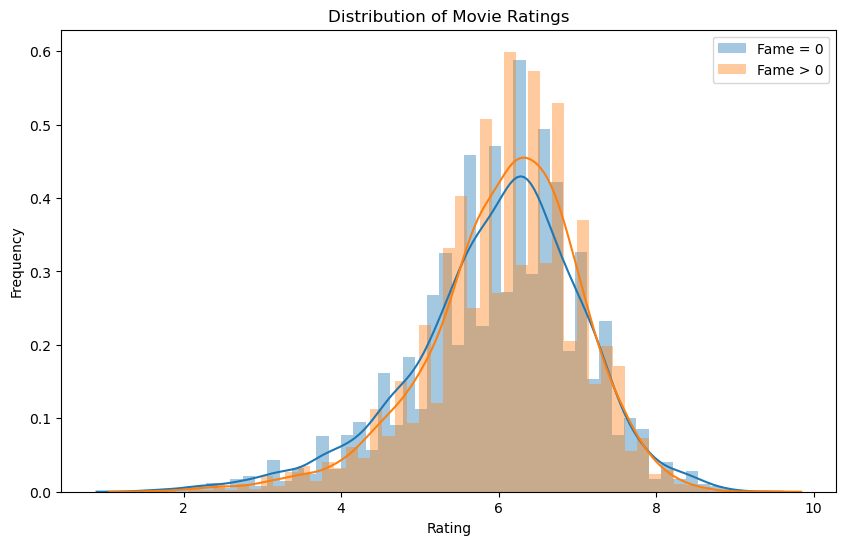

In [27]:
# plot the ratings distribution for the two groups
plt.figure(figsize=(10,6))
sns.distplot(df_zero['averageRating'], label='Fame = 0')
sns.distplot(df_positive['averageRating'], label='Fame > 0')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()


In [30]:
from scipy.stats import ttest_rel

# Extract the ratings for the two groups
ratings_zero = df_zero['averageRating']
ratings_positive = df_positive['averageRating']

# Perform the paired t-test
t_statistic, p_value = ttest_rel(ratings_zero, ratings_positive)

# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Check if the difference in means is statistically significant
if p_value < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

# interpret the results of the t-test
if t_statistic < 0:
    print("The average rating for movies with fame = 0 is higher.")
else:
    print("The average rating for movies with fame > 0 is higher.")


Paired t-test results:
t-statistic: -4.246234695541308
p-value: 2.2181545949006472e-05
The difference in means is statistically significant.
The average rating for movies with fame = 0 is higher.


In [ ]:
#regression of ratings on the fame=0 dataset, using all the features that make sense except the fame values
model = ols('averageRating ~ runtime + ', df_zero).fit()
